In [51]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt


def generate_credit_data(n_samples=1000, n_features=10, random_state=42):
    """Generuje syntetyczne dane kredytowe."""
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=6,
        n_redundant=2,
        n_clusters_per_class=2,
        random_state=random_state
    )
    return X, y


def bootstrap_sample(X, y, random_state=None):
    """Losuje probke bootstrap (n probek ze zwracaniem z n)."""
    rng = np.random.RandomState(random_state)
    n = len(X)
    indices = rng.choice(n, size=n, replace=True)
    oob_indices = list(set(range(n)) - set(indices))
    return X[indices], y[indices], oob_indices


def train_single_trees(X_train, y_train, n_trees=10):
    """Trenuje n pojedynczych drzew z roznymi seedami."""
    trees = []
    for seed in range(n_trees):
        tree = DecisionTreeClassifier(random_state=seed)
        tree.fit(X_train, y_train)
        trees.append(tree)
    return trees


def calculate_prediction_variance(trees, X):
    """Oblicza wariancje p(klasa=1) miedzy drzewami dla kazdego punktu."""
    all_probas = []
    for tree in trees:
        proba = tree.predict_proba(X)[:, 1]
        all_probas.append(proba)

    all_probas = np.vstack(all_probas)

    variances = np.var(all_probas, axis=0)
    return variances


def ensemble_predict(trees, X):
    """Agreguje predykcje wielu drzew przez glosowanie wiekszosciowe."""
    # TODO: Zbierz predykcje ze wszystkich drzew
    # TODO: Dla kazdego punktu zwroc najczesciej wystepujaca klase
    all_preds = [tree.predict(X) for tree in trees] 
    all_preds = np.vstack(all_preds)

    n_samples = all_preds.shape[1]
    y_ens = np.empty(n_samples, dtype=int)

    for i in range(n_samples):
        counts = Counter(all_preds[:, i])
        y_ens[i] = counts.most_common(1)[0][0]

    return y_ens


def calculate_oob_error(X, y, trees, oob_indices_list):
    """Oblicza OOB error bez zbioru walidacyjnego."""
    # TODO: Dla kazdego punktu uzyj tylko drzew, ktore go nie widzialy
    # TODO: Zaglosuj i porownaj z prawdziwa etykieta
    n_samples = X.shape[0]
    votes = [[] for _ in range(n_samples)]

    for tree, oob_idx in zip(trees, oob_indices_list):
        if not oob_idx:
            continue
        oob_idx = np.array(oob_idx)
        preds = tree.predict(X[oob_idx])
        for idx, pred in zip(oob_idx, preds):
            votes[idx].append(pred)

    oob_preds = np.full(n_samples, -1, dtype=int)
    used_mask = np.zeros(n_samples, dtype=bool)

    for i in range(n_samples):
        if votes[i]:
            oob_preds[i] = Counter(votes[i]).most_common(1)[0][0]
            used_mask[i] = True

    error = np.mean(oob_preds[used_mask] != y[used_mask])
    return error
    pass


Średnia wariancja: 0.013833333333333335
Max wariancja: 0.25


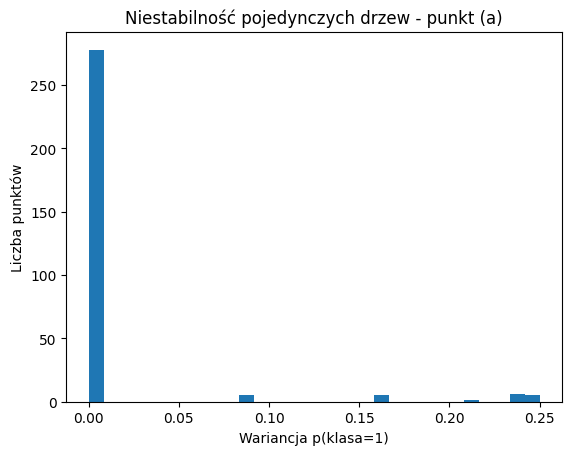

In [52]:
X, y = generate_credit_data(n_samples=1000, n_features=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

trees = train_single_trees(X_train, y_train, n_trees=10)

variances = calculate_prediction_variance(trees, X_test)

print("Średnia wariancja:", np.mean(variances))
print("Max wariancja:", np.max(variances))

plt.hist(variances, bins=30)
plt.xlabel("Wariancja p(klasa=1)")
plt.ylabel("Liczba punktów")
plt.title("Niestabilność pojedynczych drzew - punkt (a)")
plt.show()

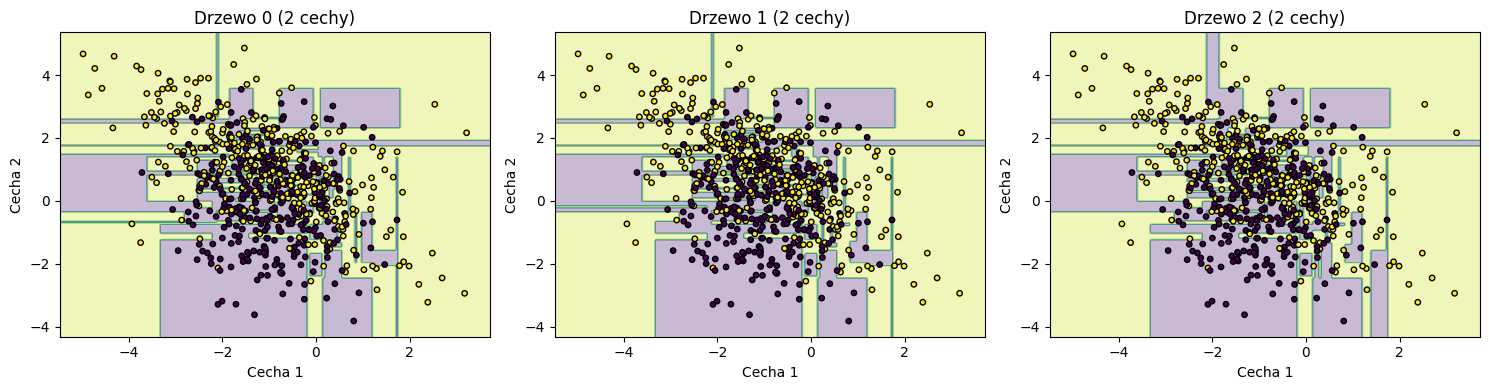

In [53]:
X_train_2d = X_train[:, :2]
trees_2d = []
for seed in range(3):
    t = DecisionTreeClassifier(random_state=seed)
    t.fit(X_train_2d, y_train)
    trees_2d.append(t)

x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

plt.figure(figsize=(15, 4))
for i, tree in enumerate(trees_2d):
    plt.subplot(1, 3, i + 1)
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(
        X_train_2d[:, 0], X_train_2d[:, 1],
        c=y_train, edgecolor="k", s=15
    )
    plt.title(f"Drzewo {i} (2 cechy)")
    plt.xlabel("Cecha 1")
    plt.ylabel("Cecha 2")

plt.tight_layout()
plt.show()


In [54]:
variances_single = variances

variances_bag_between = variances_bag

n_bag_trees = 50

variances_bag_model = variances_bag_between / n_bag_trees

print("Średnia wariancja pojedynczego drzewa      :", np.mean(variances_single))
print("Średnia wariancja modelu bagging (50 drzew):", np.mean(variances_bag_model))
print("Spadek wariancji:", np.mean(variances_single) - np.mean(variances_bag_model))


Średnia wariancja pojedynczego drzewa      : 0.013833333333333335
Średnia wariancja modelu bagging (50 drzew): 0.0018465333333333334
Spadek wariancji: 0.0119868


In [55]:
def build_randomized_tree(random_state=None):
    """Drzewo z losowaniem podzbioru cech (max_features='sqrt')."""
    return DecisionTreeClassifier(
        random_state=random_state,
        max_features='sqrt'
    )

n_rand_trees = 50
rand_trees = []

for seed in range(n_rand_trees):
    X_boot, y_boot, _ = bootstrap_sample(X_train, y_train, random_state=100 + seed)
    t = build_randomized_tree(random_state=seed)
    t.fit(X_boot, y_boot)
    rand_trees.append(t)

def collect_probas(trees, X):
    all_probas = []
    for t in trees:
        all_probas.append(t.predict_proba(X)[:, 1])
    return np.vstack(all_probas)

probas_bag = collect_probas(bagged_trees, X_test)
probas_rand = collect_probas(rand_trees, X_test)

def avg_pairwise_corr(all_probas):
    """Średnia parowa korelacja Pearsona między drzewami."""
    n_trees = all_probas.shape[0]
    cors = []
    for i in range(n_trees):
        for j in range(i + 1, n_trees):
            r = np.corrcoef(all_probas[i], all_probas[j])[0, 1]
            cors.append(r)
    return np.mean(cors)

avg_corr_bag = avg_pairwise_corr(probas_bag)
avg_corr_rand = avg_pairwise_corr(probas_rand)

print("Średnia korelacja między drzewami (zwykły bagging):", avg_corr_bag)
print("Średnia korelacja między drzewami (max_features='sqrt'):", avg_corr_rand)


Średnia korelacja między drzewami (zwykły bagging): 0.6244551404999101
Średnia korelacja między drzewami (max_features='sqrt'): 0.5560890926946762


10 drzew -> OOB error = 0.136, test error = 0.140
50 drzew -> OOB error = 0.103, test error = 0.127
100 drzew -> OOB error = 0.099, test error = 0.117
200 drzew -> OOB error = 0.081, test error = 0.117
500 drzew -> OOB error = 0.096, test error = 0.127


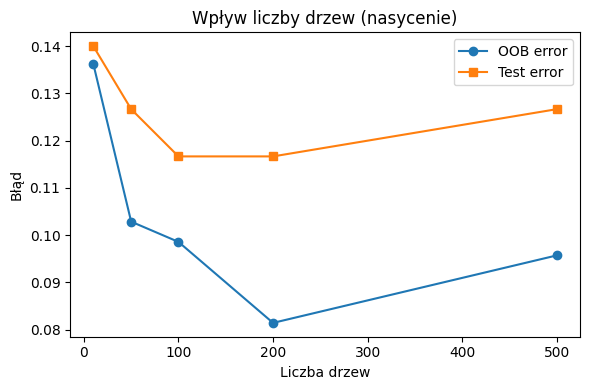

In [ ]:
from sklearn.model_selection import train_test_split

X, y = generate_credit_data(n_samples=1000, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

def train_bagged_random_forest(X_train, y_train, n_trees, seed_offset=0):
    """Buduje n drzew z bootstrap + max_features='sqrt', zwraca drzewa i listę OOB."""
    trees = []
    oob_indices_list = []
    for i in range(n_trees):
        X_boot, y_boot, oob_idx = bootstrap_sample(X_train, y_train,
                                                   random_state=seed_offset + i)
        t = build_randomized_tree(random_state=seed_offset + i)
        t.fit(X_boot, y_boot)
        trees.append(t)
        oob_indices_list.append(oob_idx)
    return trees, oob_indices_list

n_list = [10, 50, 100, 200, 500]
oob_errors = []
test_errors = []

for n_trees in n_list:
    trees, oob_idx_list = train_bagged_random_forest(X_train, y_train, n_trees)
    oob_err = calculate_oob_error(X_train, y_train, trees, oob_idx_list)
    oob_errors.append(oob_err)

    y_pred = ensemble_predict(trees, X_test)
    test_err = np.mean(y_pred != y_test)
    test_errors.append(test_err)

    print(f"{n_trees} drzew -> OOB error = {oob_err:.3f}, test error = {test_err:.3f}")

plt.figure(figsize=(6,4))
plt.plot(n_list, oob_errors, marker="o", label="OOB error")
plt.plot(n_list, test_errors, marker="s", label="Test error")
plt.xlabel("Liczba drzew")
plt.ylabel("Błąd")
plt.title("Wpływ liczby drzew (nasycenie)")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
from sklearn.ensemble import RandomForestClassifier

print("\nPorównanie z sklearn.ensemble.RandomForestClassifier:")

for n_trees in n_list:
    rf = RandomForestClassifier(
        n_estimators=n_trees,
        max_features='sqrt',
        bootstrap=True,
        oob_score=True,
        random_state=42
    )
    rf.fit(X_train, y_train)
    rf_oob_error = 1.0 - rf.oob_score_
    rf_test_error = 1.0 - rf.score(X_test, y_test)

    print(f"{n_trees} drzew -> "
          f"nasz OOB ≈ {oob_errors[n_list.index(n_trees)]:.3f}, "
          f"RF OOB = {rf_oob_error:.3f}, "
          f"nasz test ≈ {test_errors[n_list.index(n_trees)]:.3f}, "
          f"RF test = {rf_test_error:.3f}")



Porównanie z sklearn.ensemble.RandomForestClassifier:
10 drzew -> nasz OOB ≈ 0.136, RF OOB = 0.184, nasz test ≈ 0.140, RF test = 0.123
50 drzew -> nasz OOB ≈ 0.103, RF OOB = 0.110, nasz test ≈ 0.127, RF test = 0.117
100 drzew -> nasz OOB ≈ 0.099, RF OOB = 0.110, nasz test ≈ 0.117, RF test = 0.107


C:\Users\milen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


200 drzew -> nasz OOB ≈ 0.081, RF OOB = 0.097, nasz test ≈ 0.117, RF test = 0.110
500 drzew -> nasz OOB ≈ 0.096, RF OOB = 0.097, nasz test ≈ 0.127, RF test = 0.117
